<h2>Demographic Factors Modeling Tuned for Area-Under-the-Curve (AUC)</h2>

In this notebook, we once again utilize Optuna to optimize for AUC using variables that are considered demographic, most of which are not mutable attributes of an individual patient, and therefore are not necessarily informative for interventional purposes. These factors can compound with controllable ones, however. Insights from this analysis can also be used to assess baseline risk.

We utilize the TPESampler as our primary optimization algorithm, and utilize median pruining - that is, if the AUC result is worse than the current median, the test is scrapped. We compare versions of LogisticRegression, RandomForest, and XGBoost with tuned hyperparameters.

More detailed results can be found in our final report!

<h2>Note</h2>

These optimization loops can also take awhile, so please be patient! You will see (and read about why we did so in the report) that we decided to scrap one of the trials because we felt we already had enough information and a performative enough model.

In [5]:
import os
import sys
from pathlib import Path
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    log_loss,
    roc_auc_score

)
from sklearn.dummy import DummyClassifier
import shap

src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from expanding_scaler import global_expanding_standard_scaler_by_date

BASE_DIR = Path().resolve().parent

In [4]:
class OptimizerClassifier():
    def __init__(
            self,
            search_iter=5000,
            decision_threshold=0.5,
            scoring_metric='recall',
            xgb_objective='binary:logistic',
            random_state=42,
            n_jobs=-1
    ):
        self.search_iter = search_iter
        self.decision_threshold = decision_threshold
        self.scoring_metric = scoring_metric
        self.xgb_objective = xgb_objective
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.base_params = {
            "random_state": self.random_state,
            "n_jobs": self.n_jobs,
        }
        self.scorer = self._make_scorer_cust(self.scoring_metric)
        self.binary_vars = None
        self.date_col = None
        self.cv = None
        self.scaled_data = {}
        self.best_estimator = None
        self.best_score = None
        self.best_params = None
        self.best_use_balance = None

    def _make_scorer_cust(self, scoring_metric: str):
        if scoring_metric in ['logloss', 'mlogloss']:
            return log_loss
        # Uses 1 - accuracy to align with XGBoost error.
        elif scoring_metric in ['error', 'merror']:
            return lambda y_true, y_pred: 1 - (accuracy_score(y_true, y_pred))
        elif scoring_metric == "recall":
            return recall_score
        elif scoring_metric == "precision":
            return precision_score
        elif scoring_metric == "auc":
            return roc_auc_score
        else:
            raise ValueError(f"Unsupported scoring metric: {scoring_metric}")
    
    def _get_scaled_train_test_groups(self, X, y):

        order_idx = X[self.date_col].sort_values().index
        X_sorted = X.loc[order_idx]

        cont_cols = [c for c in X.columns if c not in self.binary_vars and c != self.date_col]
                
        if self.cv is None:
            
            tscv = TimeSeriesSplit(
                n_splits=3,
                test_size=int(round(X_sorted.shape[0] * 0.10, 0)),
                gap=0,
            )
            self.cv = list(tscv.split(X_sorted))

            for split, (train_index, test_index) in enumerate(self.cv):
                X_train, X_test = X_sorted.iloc[train_index], X_sorted.iloc[test_index]

                X_train_scaled = X_train.copy()
                X_test_scaled  = X_test.copy()

                X_train_scaled[cont_cols] = X_train_scaled[cont_cols].astype(float)
                X_test_scaled[cont_cols]  = X_test_scaled[cont_cols].astype(float)

                train_for_scaler = X_train_scaled[cont_cols + [self.date_col]]
                train_scaled_full, train_scaler_state = global_expanding_standard_scaler_by_date(
                    train_for_scaler,
                    date_col=self.date_col,
                    merge_cols=[self.date_col],
                    min_periods=0,
                    return_stats=True,
                )
                X_train_scaled.loc[train_scaled_full.index, cont_cols] = train_scaled_full[cont_cols]

                test_for_scaler = X_test_scaled[cont_cols + [self.date_col]]
                test_scaled_full = global_expanding_standard_scaler_by_date(
                    test_for_scaler,
                    date_col=self.date_col,
                    merge_cols=[self.date_col],
                    min_periods=0,
                    stats=train_scaler_state,
                    return_stats=False,
                )
                X_test_scaled.loc[test_scaled_full.index, cont_cols] = test_scaled_full[cont_cols]

                X_train_lr = X_train_scaled.drop(columns=[self.date_col])
                X_test_lr = X_test_scaled.drop(columns=[self.date_col])

                self.scaled_data[f'train_{split}'] = X_train_lr
                self.scaled_data[f'test_{split}'] = X_test_lr

            X_group_needs_scaling = X[cont_cols + [self.date_col]]
            X_group_scaled = global_expanding_standard_scaler_by_date(
                X_group_needs_scaling,
                date_col=self.date_col,
                merge_cols=[self.date_col],
                min_periods=0
            )

            X_group_scaled_full = X.copy()
            X_group_scaled_full[cont_cols] = X_group_scaled[cont_cols]

            X_group_scaled_no_date = X_group_scaled_full.drop(columns=[self.date_col])
            self.scaled_data['all'] = X_group_scaled_no_date

    def _eval_classifier(self, X, y, model_params, trial):

        if self.cv is None:
            raise ValueError('self.cv is not set.')
        
        order_idx = X[self.date_col].sort_values().index
        y_sorted = y.loc[order_idx]
        
        fold_scores = []
        for split, (train_index, test_index) in enumerate(self.cv):
            
            smote = SMOTE(random_state=self.random_state)
            X_train, y_train = smote.fit_resample(self.scaled_data[f'train_{split}'], y_sorted.iloc[train_index])

            X_test  = self.scaled_data[f'test_{split}']
            y_test = y_sorted.iloc[test_index]
            
            
            # We aren't using the pruining callback because it would interrupt the
            # k-fold cross-validation. Instead, we use early stopping as a parameter
            # of the model, and allow Optuna to then decide where to search next.
            model = self.ModelClass(**model_params)

            if self.ModelClass is XGBClassifier:
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_test, y_test)],
                    verbose=False
                )
            else:
                model.fit(X_train,y_train)
            # During training with an eval_set and early_stopping_rounds,
            # XGBoost tracks the validation score at each boosting round.
            # When validation stops improving for early_stopping_rounds
            # consecutive rounds, training halts and best_iteration is then
            # set to the boosting round (0-based index) with the best validation score.
            best_iter = getattr(model, "best_iteration", None)
            use_proba = self.scoring_metric in ("logloss", "mlogloss", "auc")

            if best_iter is not None:
                y_proba_test = model.predict_proba(X_test, iteration_range=(0, best_iter + 1))[:, 1]
            else:
                y_proba_test = model.predict_proba(X_test)[:, 1]
            
            # yhat_train = (y_proba_train >= decision_threshold).astype(int)
            yhat_test = (y_proba_test  >= self.decision_threshold).astype(int)

            if use_proba:
                fold_score = self.scorer(y_test, y_proba_test)
            else:
                fold_score = self.scorer(y_test, yhat_test)

            if self.ModelClass is XGBClassifier:
                trial.report(fold_score, step=split)
                if trial.should_prune():
                    raise optuna.TrialPruned()

            fold_scores.append(fold_score)
        
        return float(np.mean(fold_scores))

    def _run_optimization(self, X, y):

        self._get_scaled_train_test_groups(X, y)

        def __objective(trial: optuna.Trial) -> float:

            if self.cv is None or not isinstance(self.cv, list):
                raise ValueError('cv_splits is not set.')
            if X is None:
                raise ValueError('X is not set.')
            if y is None:
                raise ValueError('y is not set.')
            if self.ModelClass is None:
                raise ValueError('ModelClass is not set.')
            
            if self.ModelClass is XGBClassifier:
                neg = (y == 0).sum()
                pos = (y == 1).sum()
                balance_eq = neg / pos

                use_balance = trial.suggest_categorical("use_balance_weight", [True, False])
                model_params = {
                    **self.base_params,
                    "n_estimators": 3000,
                    "early_stopping_rounds": 50,
                    "objective": self.xgb_objective,
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
                    "max_depth": trial.suggest_int("max_depth", 3, 10),
                    "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 20.0, log=True),
                    "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                    "gamma": trial.suggest_float("gamma", 1e-9, 10.0, log=True),
                }
                if use_balance:
                    model_params["scale_pos_weight"] = balance_eq
            elif self.ModelClass is RandomForestClassifier:
                model_params = {
                    **self.base_params,
                    "bootstrap": True,
                    "n_estimators": trial.suggest_int("n_estimators", 10, 300),
                    "max_depth": trial.suggest_int("max_depth", 3, 10),
                    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                    "class_weight": trial.suggest_categorical("class_weight", ["balanced", None])
            }
            else:
                model_params = {
                    **self.base_params,
                    "max_iter": 1000,
                    # "solver": "liblinear",
                    "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
                    "C": trial.suggest_float("C", 1e-9, 10.0, log=True),
                    #"penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
                }
            

            score = self._eval_classifier(X, y, model_params, trial)

            return score
        
        if self.scoring_metric in ("logloss", "mlogloss", "error", "merror"):
            direction = "minimize"
        else:
            direction = "maximize"
        
        study = optuna.create_study(
            direction=direction,
            pruner=MedianPruner(n_min_trials=self.search_iter // 2),
            sampler=TPESampler(seed=self.random_state)
        )
        study.optimize(
                __objective,
            n_trials=self.search_iter
        )

        order_idx = X[self.date_col].sort_values().index
        X_all_scaled = self.scaled_data['all'].loc[order_idx]
        y_sorted = y.loc[order_idx]

        study_params = dict(study.best_params)

        use_balance = study_params.pop("use_balance_weight", None)
        best_model_params = {**self.base_params, **study_params}
        best_estimator = self.ModelClass(**best_model_params)
        best_estimator.fit(X_all_scaled, y_sorted)

        self.best_estimator = best_estimator
        self.best_score = study.best_value
        self.best_params = best_model_params
        self.best_use_balance = use_balance

    def fit_transform(
        self,
        X,
        y,
        date_col,
        binary_vars=None,
        model_type='xgb_clf'
    ):
        
        self.date_col = date_col
        self.binary_vars = binary_vars or []
        
        if model_type == 'xgb_clf':
            self.ModelClass = XGBClassifier
        elif model_type == 'lr':
            self.ModelClass = LogisticRegression
        elif model_type == 'rf':
            self.ModelClass = RandomForestClassifier
        else:
            raise ValueError(f"Model type {model_type} is not supported.")
        
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        X = X.dropna(subset=[self.date_col])

        self._run_optimization(X, y)

        return (self.best_estimator, self.best_score, self.best_params)

In [5]:
race_map = {
    1.0: "White",
    2.0: "Black",
    3.0: "AIAN",
    4.0: "Asian",
    5.0: "NHOPI",
    6.0: "Multiple/Other",
    9.0: None,
    99.0: None
}

def map_hisp(x):
    if pd.isna(x):
        return np.nan
    try:
        v = int(x)
    except:
        return np.nan
    if v == 0:
        return 0
    if v in (1, 2, 3, 4, 5, 6):
        return 1
    return 9


def load_and_preprocess(
    files_path: Path,
    chunk_size: int = 100_000,
    sample_frac: float = 1.0
):
    """
    Loads natality data in chunks, applies optional sampling,
    converts IP_ columns, creates indicators, maps race & hispanic,
    one-hot encodes race, and returns a numeric DataFrame.
    """

    first_cols = pd.read_csv(files_path, nrows=0).columns
    ip_cols = [c for c in first_cols if c.lower().startswith("ip_")]

    usecols = [
        "mager", "fagecomb",
        "mrace6", "mracehisp",
        "frace6", "fracehisp",
        "priordead", "priorlive", "priorterm",
        "bmi", "meduc", "feduc",
        "morbidity_reported", "date"
    ] + ip_cols

    rename_map = {
        "bmi": "Body Mass Index",
        "meduc": "Mother Education",
        "feduc": "Father Education",
        "mrace6": "Mother Race",
        "mracehisp": "Mother Hispanic",
        "frace6": "Father Race",
        "fracehisp": "Father Hispanic",
        "mager": "Mother Age",
        "fagecomb": "Father Age",
        "priordead": "Prior Pregnancy Deaths",
        "priorlive": "Prior Pregnancy Live Births",
        "priorterm": "Prior Pregnancy Termination",
        "morbidity_reported": "Maternal Morbidity",
        "date": "Date of Birth",
    }

    dfs = []
    reader = pd.read_csv(files_path, chunksize=chunk_size, usecols=usecols)

    for chunk in reader:
        sampled = chunk.sample(frac=sample_frac, random_state=123)

        ip_present = [c for c in ip_cols if c in sampled.columns]
        if ip_present:
            sampled[ip_present] = sampled[ip_present].apply(
                pd.to_numeric, errors="coerce"
            ).fillna(0)

        sampled["Infection Present"] = (
            sampled[ip_present].sum(axis=1) > 0
        ).astype(int)

        sampled.drop(columns=ip_present, inplace=True)

        sampled["mrace6"] = sampled["mrace6"].map(race_map)
        sampled["frace6"] = sampled["frace6"].map(race_map)

        sampled["mracehisp"] = sampled["mracehisp"].apply(map_hisp)
        sampled["fracehisp"] = sampled["fracehisp"].apply(map_hisp)

        sampled.rename(columns=rename_map, inplace=True)

        dfs.append(sampled)
        break

    df = pd.concat(dfs, ignore_index=True)

    for col in df.columns:
        if col != "Maternal Morbidity":
            df[col] = df[col].fillna(9)


    df = df.dropna()

    df["Maternal Morbidity"] = df["Maternal Morbidity"].astype(int)

    return df

In [6]:
path = BASE_DIR / 'data_main' / 'natality_aligned_10pct_sample.csv' 

clean_df = load_and_preprocess(path)

clean_df

,Mother Age,Mother Race,Mother Hispanic,Mother Education,Father Age,Father Race,Father Hispanic,Father Education,Prior Pregnancy Live Births,Prior Pregnancy Deaths,Prior Pregnancy Termination,Body Mass Index,Maternal Morbidity,Date of Birth,Infection Present
0,25,White,9,3.0,26.0,White,9.0,3.0,2.0,0.0,0.0,32.200001,0,2020-01-27,0
1,33,Black,1,3.0,41.0,Black,9.0,4.0,1.0,0.0,0.0,27.799999,0,2020-01-06,0
2,28,White,9,2.0,29.0,White,9.0,2.0,1.0,0.0,0.0,20.600000,0,2020-02-03,0
3,17,White,9,2.0,22.0,White,9.0,2.0,1.0,0.0,2.0,28.299999,0,2020-02-10,0
4,27,White,9,3.0,9.0,9,9.0,9.0,3.0,0.0,0.0,39.099998,0,2020-02-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,28,White,1,7.0,31.0,White,1.0,6.0,0.0,0.0,0.0,20.200001,0,2020-02-03,0
99996,21,Multiple/Other,1,4.0,24.0,White,1.0,4.0,2.0,0.0,0.0,26.900000,0,2020-02-03,0
99997,26,White,9,6.0,28.0,White,9.0,2.0,1.0,0.0,0.0,21.700001,0,2020-02-10,1
99998,36,White,9,4.0,42.0,White,9.0,1.0,3.0,0.0,0.0,30.700001,0,2020-02-10,0


In [13]:
oh_df = clean_df.copy()

low_card_cols = [
    c for c in oh_df.columns
    if c != "Maternal Morbidity" and oh_df[c].nunique() < 10
]

str_cat_cols = []
int_cat_cols = []

for c in low_card_cols:
    vals = oh_df[c].dropna()
    types = {type(v) for v in vals}

    if types <= {str}:
        str_cat_cols.append(c)

    elif np.issubdtype(vals.dtype, np.number) and not (str in types):
        int_cat_cols.append(c)

    else:
        oh_df[c] = oh_df[c].astype(str)
        str_cat_cols.append(c)

oh_encoder_str = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
oh_encoder_int = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

if str_cat_cols:
    oh_str_arr = oh_encoder_str.fit_transform(oh_df[str_cat_cols])
    oh_str = pd.DataFrame(
        oh_str_arr,
        columns=oh_encoder_str.get_feature_names_out(str_cat_cols),
        index=oh_df.index,
    )
else:
    oh_str = pd.DataFrame(index=oh_df.index)

if int_cat_cols:
    oh_int_arr = oh_encoder_int.fit_transform(oh_df[int_cat_cols])
    oh_int = pd.DataFrame(
        oh_int_arr,
        columns=oh_encoder_int.get_feature_names_out(int_cat_cols),
        index=oh_df.index,
    )
else:
    oh_int = pd.DataFrame(index=oh_df.index)

non_cat_cols = [
    c for c in oh_df.columns
    if c not in (str_cat_cols + int_cat_cols + ["Maternal Morbidity"])
]
X_num = oh_df[non_cat_cols]

X_one_hot = pd.concat([X_num, oh_str, oh_int, oh_df['Date of Birth']], axis=1)

y = clean_df["Maternal Morbidity"].astype(int)

X_cat = clean_df.drop(columns=["Maternal Morbidity"])

binary_vars_oh = [c for c in X_one_hot.columns if X_one_hot[c].nunique() == 2]
binary_vars_cat = [c for c in X_cat.columns if X_cat[c].nunique() == 2]

In [8]:
dummy = DummyClassifier(strategy='uniform')
dummy2 = DummyClassifier(strategy='stratified')

dummy.fit(X_cat.drop('Date of Birth', axis=1), y)
dummy2.fit(X_cat.drop('Date of Birth', axis=1), y)

y_pred = dummy.predict(X_cat)
y_pred2 = dummy2.predict(X_cat)

print(f"Dummy AUC:  {roc_auc_score(y, y_pred,  average='macro')}")
print(f"Dummy2 AUC: {roc_auc_score(y, y_pred2, average='macro')}")

Dummy AUC:  0.4977218940127541
Dummy2 AUC: 0.5016552539283419


In [9]:
mother_dummies = pd.get_dummies(X_cat["Mother Race"], prefix="MotherRace")
father_dummies = pd.get_dummies(X_cat["Father Race"], prefix="FatherRace")
mracehisp_dummies = pd.get_dummies(X_cat["Mother Hispanic"], prefix="MotherHisp")
fracehisp_dummies = pd.get_dummies(X_cat["Father Hispanic"], prefix="FatherHisp")

X_cat = X_cat.drop(columns=[
    "Mother Race", "Father Race", "Mother Hispanic", "Father Hispanic"
])

X_cat = pd.concat(
    [X_cat, mother_dummies, father_dummies, mracehisp_dummies, fracehisp_dummies],
    axis=1
)

date_series = pd.to_datetime(X_cat["Date of Birth"], errors="raise")

X_num = X_cat.drop(columns=["Date of Birth"])

X_num = X_num.apply(pd.to_numeric, errors="raise").astype("float64")

X_cat = pd.concat([X_num, date_series.rename("Date of Birth")], axis=1)

binary_vars_cat = [c for c in X_cat.columns if c != "Date of Birth" and X_cat[c].nunique() == 2]

In [10]:
optimizer_rf = OptimizerClassifier(
    search_iter=100,
    random_state=42,
    decision_threshold=0.5,
    scoring_metric='auc',
    xgb_objective='binary:logistic',
    n_jobs=-1
)

best_rf_model, best_rf_score, best_rf_params = optimizer_rf.fit_transform(
    X_cat,
    y,
    date_col='Date of Birth',
    binary_vars=binary_vars_cat,
    model_type='rf'
)

[I 2025-12-08 07:49:20,802] A new study created in memory with name: no-name-3d95ff66-af30-4524-9684-17d33cfbf38e
[I 2025-12-08 07:49:27,377] Trial 0 finished with value: 0.6524536896306827 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6524536896306827.
[I 2025-12-08 07:49:28,890] Trial 1 finished with value: 0.6446382381763778 and parameters: {'n_estimators': 26, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight': None}. Best is trial 0 with value: 0.6524536896306827.
[I 2025-12-08 07:49:34,561] Trial 2 finished with value: 0.649170863983655 and parameters: {'n_estimators': 252, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'class_weight': None}. Best is trial 0 with value: 0.6524536896306827.
[I 2025-12-08 07:49:38,288] Trial 3 finished with value: 0.6535323042891937 and parameters: {'n_estimators': 135, 'max_depth': 5, 'min_sa

In [11]:
optimizer_xgb = OptimizerClassifier(
    search_iter=100,
    random_state=42,
    decision_threshold=0.5,
    scoring_metric='auc',
    xgb_objective='binary:logistic',
    n_jobs=-1
)

best_xgb_model, best_xgb_score, best_xgb_params = optimizer_xgb.fit_transform(
    X_cat,
    y,
    date_col='Date of Birth',
    binary_vars=binary_vars_cat,
    model_type='xgb_clf'
)

[I 2025-12-08 07:55:26,807] A new study created in memory with name: no-name-d586420a-5324-46c7-bb72-cfb7cccccaa4
[I 2025-12-08 07:55:32,633] Trial 0 finished with value: 0.6171540145480926 and parameters: {'use_balance_weight': False, 'learning_rate': 0.06504856968981275, 'max_depth': 7, 'min_child_weight': 0.8890398459575589, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'gamma': 0.4589458612326473}. Best is trial 0 with value: 0.6171540145480926.
[I 2025-12-08 07:56:19,474] Trial 1 finished with value: 0.6530884148596057 and parameters: {'use_balance_weight': False, 'learning_rate': 0.001124579825911934, 'max_depth': 10, 'min_child_weight': 10.779361932748845, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 6.824095540630416e-08}. Best is trial 1 with value: 0.6530884148596057.
[I 2025-12-08 07:56:35,725] Trial 2 finished with value: 0.6310768763325939 and parameters: {'use_balance_weight': False, 'learning_rate': 0.0117484

In [14]:
optimizer_lr = OptimizerClassifier(
    search_iter=100,
    random_state=42,
    decision_threshold=0.5,
    scoring_metric='auc',
    xgb_objective='binary:logistic',
    n_jobs=-1
)

best_lr_model, best_lr_score, best_lr_params = optimizer_lr.fit_transform(
    X_one_hot,
    y,
    date_col='Date of Birth',
    binary_vars=binary_vars_oh,
    model_type='lr'
)

[I 2025-12-08 08:48:50,743] A new study created in memory with name: no-name-86e4ed80-b434-46f3-bcca-cc3fcedde465
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framewo

In [15]:
X_lr_design  = optimizer_lr.scaled_data["all"]
X_rf_design  = optimizer_rf.scaled_data["all"]
X_xgb_design = optimizer_xgb.scaled_data["all"]

feat_cols = X_rf_design.columns 

# LR importances at coef-dummy level
lr_raw_imp = np.abs(best_lr_model.coef_[0])
lr_imp_series = pd.Series(lr_raw_imp, index=X_lr_design.columns)

# Take mean coef of each dummy variable to get feature importance
# aligned with XGB and RF
agg_lr_imp = {}
for col in X_cat.columns:
    if col in str_cat_cols + int_cat_cols:
        dummy_cols = [c for c in lr_imp_series.index if c.startswith(col + "_")]
        if dummy_cols:
            agg_lr_imp[col] = lr_imp_series[dummy_cols].mean()
        else:
            agg_lr_imp[col] = 0.0
    else:
        agg_lr_imp[col] = lr_imp_series.get(col, 0.0)

feat_imp = pd.DataFrame({"feature": feat_cols})
feat_imp["LR"] = feat_imp["feature"].map(agg_lr_imp)
feat_imp["RF"]  = best_rf_model.feature_importances_
feat_imp["XGB"] = best_xgb_model.feature_importances_

# Normalize each column
for col in ["LR", "RF", "XGB"]:
    max_val = feat_imp[col].max()
    if max_val != 0:
        feat_imp[col] = feat_imp[col] / max_val

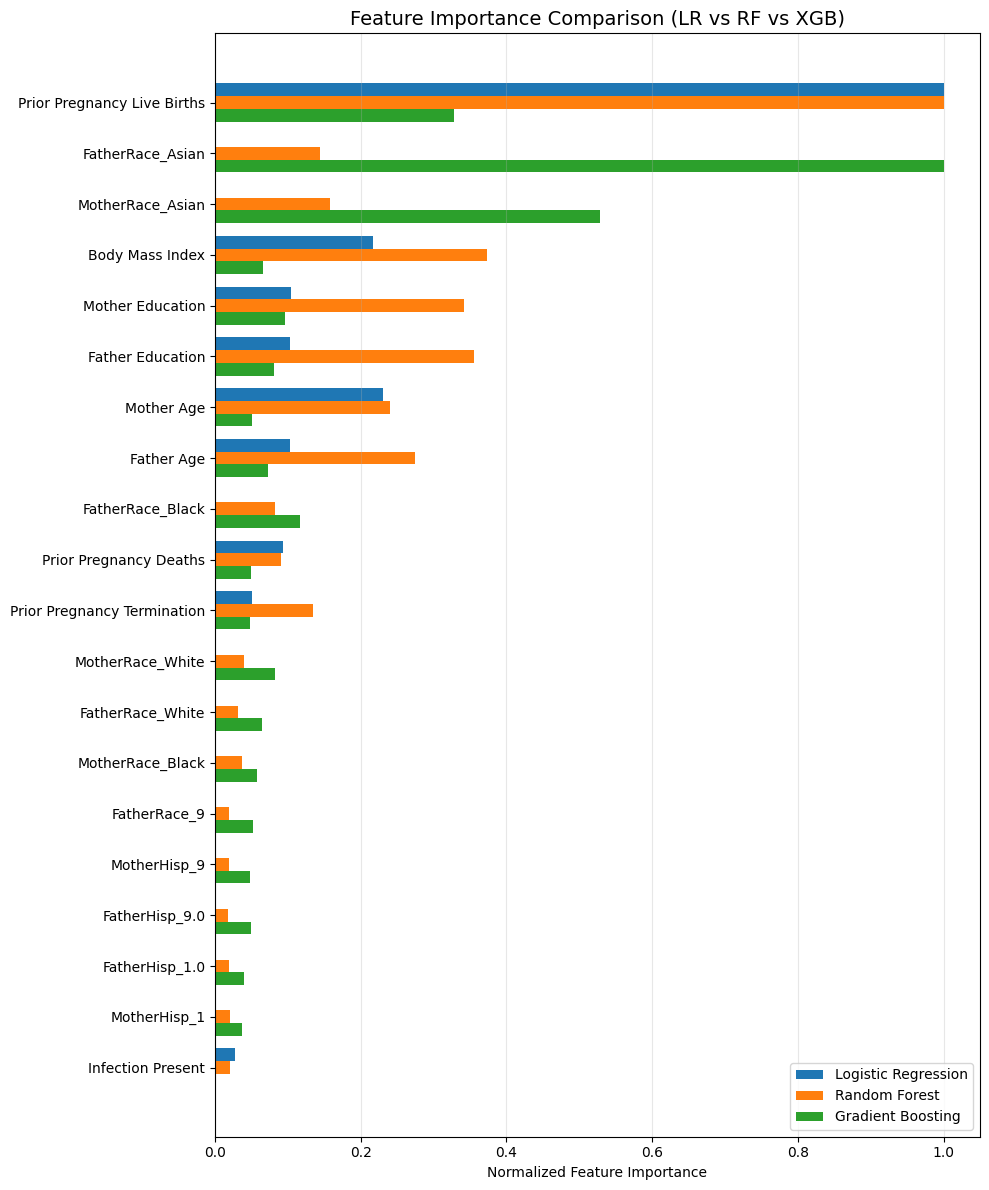

In [18]:
feat_imp["mean_importance"] = feat_imp[["LR", "RF", "XGB"]].mean(axis=1)
top = feat_imp.sort_values("mean_importance", ascending=False).head(20)

plt.figure(figsize=(10, 12))

bar_width = 0.25
x = np.arange(len(top))

plt.barh(x - bar_width, top["LR"], height=bar_width, label="Logistic Regression")
plt.barh(x, top["RF"], height=bar_width, label="Random Forest")
plt.barh(x + bar_width, top["XGB"], height=bar_width, label="Gradient Boosting")

plt.yticks(x, top["feature"])
plt.gca().invert_yaxis()
plt.xlabel("Normalized Feature Importance")
plt.title("Feature Importance Comparison (LR vs RF vs XGB)", fontsize=14)
plt.legend()
plt.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
def shap_bar_plot(model, X_test, max_display=20):
    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(
        shap_values,
        X_test,
        plot_type="bar",
        max_display=max_display
    )
    return

def plot_partial_dependence_grid(model, X, feature_list, n_rows=3, n_cols=3):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
    axes = axes.ravel()

    for ax, feat in zip(axes, feature_list):
        if feat not in X.columns:
            ax.set_visible(False)
            continue

        PartialDependenceDisplay.from_estimator(
            model,
            X,
            [feat],
            ax=ax,
        )

    # Hide any unused axes
    for j in range(len(feature_list), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


Plotting partial dependence plots (XGBoost)...


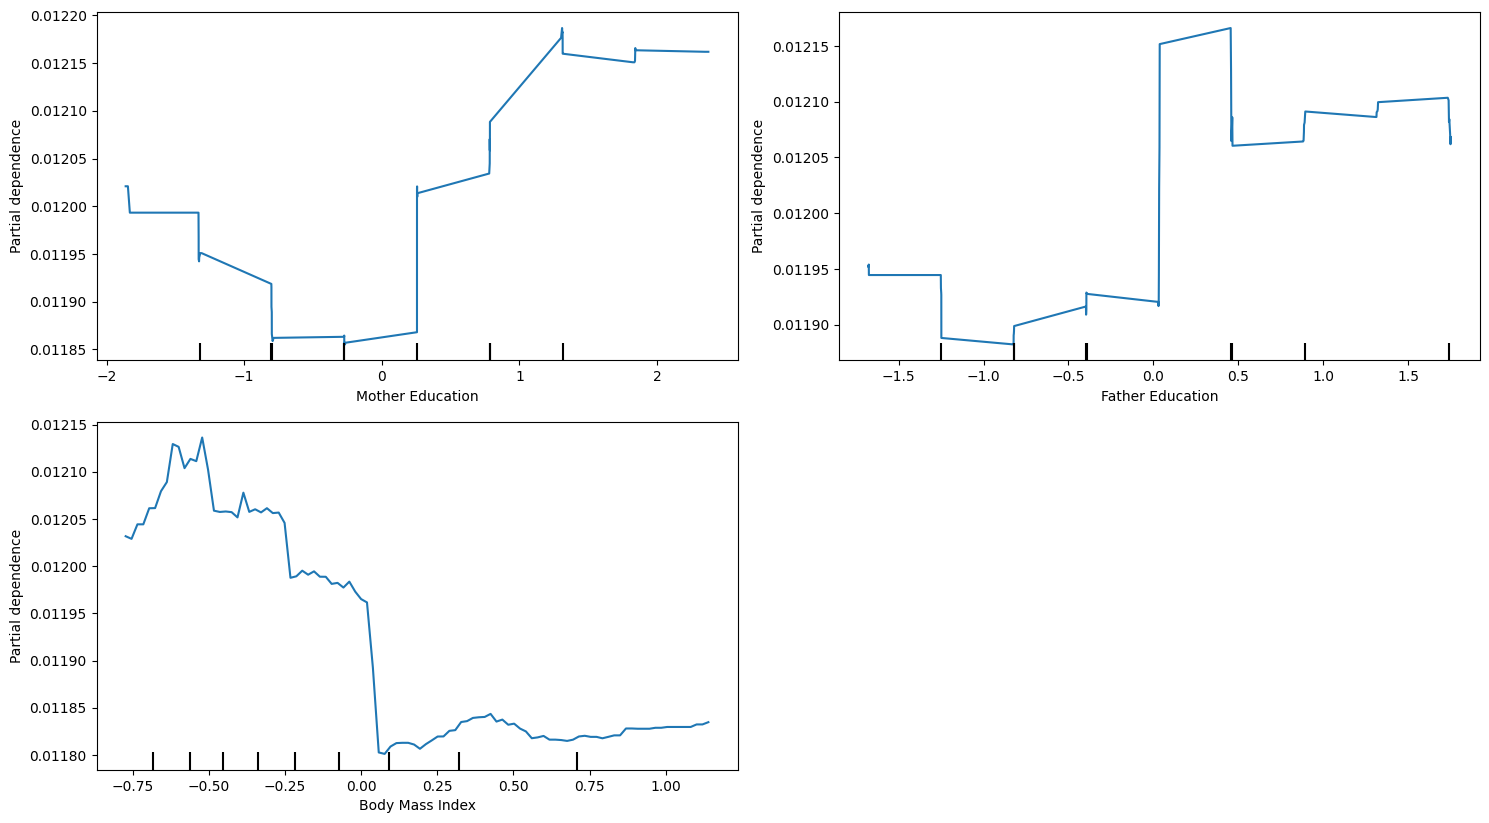

In [20]:
pdp_features = [
    "Pre-natal Visits",
    "Mother Education",
    "Father Education",
    "Final Route of Delivery",
    # "Payment Method",
    "Body Mass Index",
    "Medical Provider",
    # "Risk Factor Present",
]
pdp_features = [f for f in pdp_features if f in feat_cols]

if pdp_features:
    print("\nPlotting partial dependence plots (XGBoost)...")
    plot_partial_dependence_grid(
        best_xgb_model,
        optimizer_xgb.scaled_data["all"],
        pdp_features,
        n_rows=3,
        n_cols=2
    )

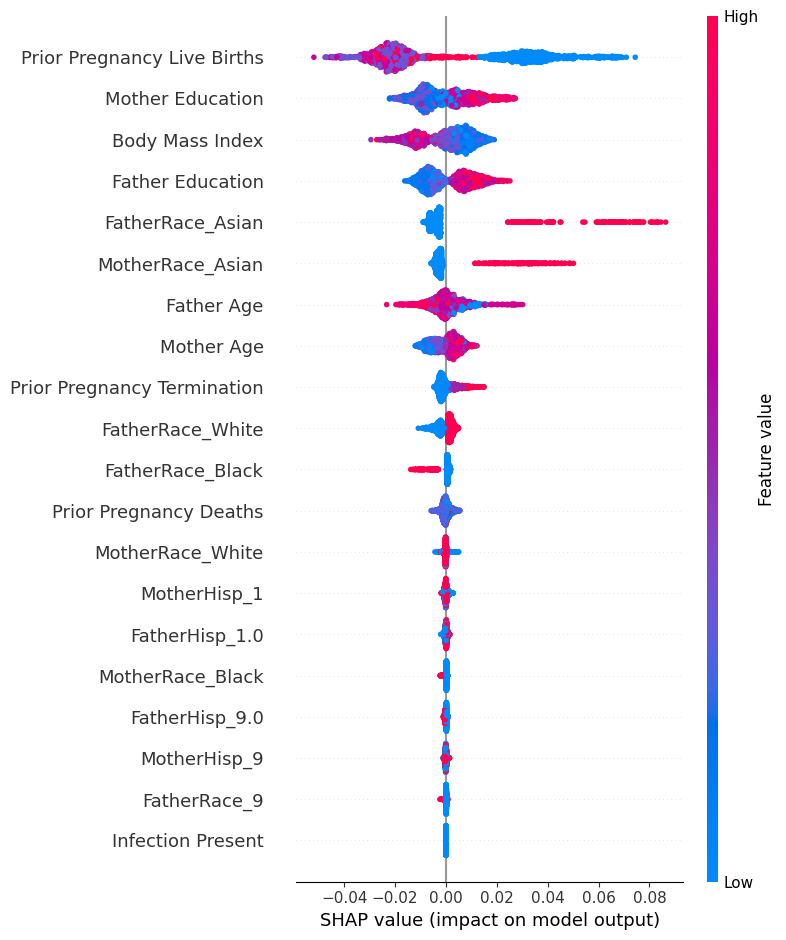

In [21]:
sampled_for_shap = optimizer_xgb.scaled_data["all"].sample(2000, random_state=42)

# SHAP analysis
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(sampled_for_shap)

# Global importance
shap.summary_plot(shap_values, sampled_for_shap)